In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to C:\Users\Rahul
[nltk_data]     Shaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv('twitter_training.csv', header=None)
df

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [3]:
# Rename columns
df.columns = ['ID', 'Entity', 'Sentiment', 'Text']

# Drop rows with missing 'Text' values
df = df.dropna(subset=['Text'])

# Ensure 'Text' is of type string
df['Text'] = df['Text'].astype(str)

# Display the first few rows of the dataset
print(df.head())


     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


C:\Users\Rahul Shaw\AppData\Local\Temp\ipykernel_1536\3663025616.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].astype(str)


In [4]:
# Check for duplicate values
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicate rows: 2340


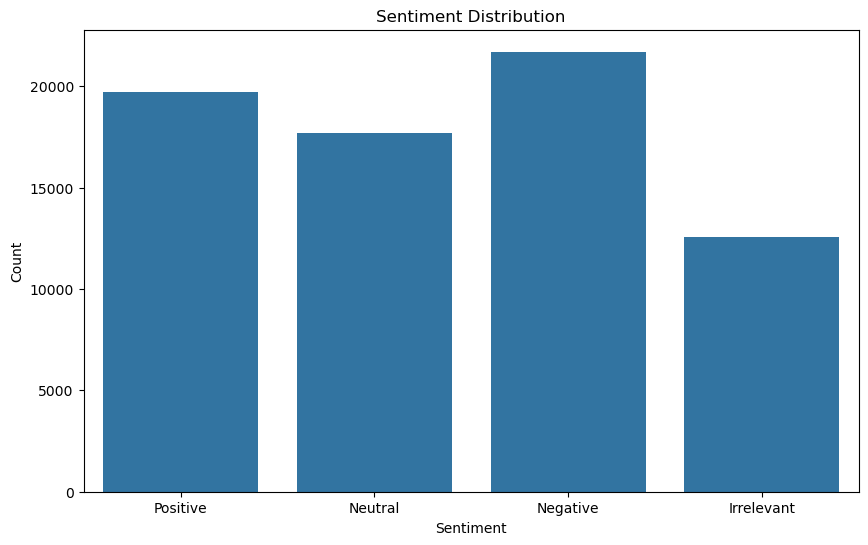

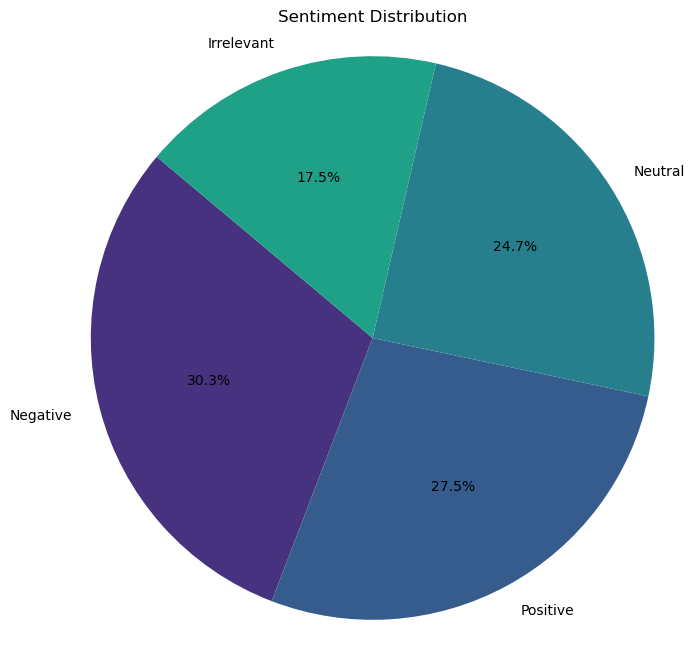

In [5]:
# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot pie chart for sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

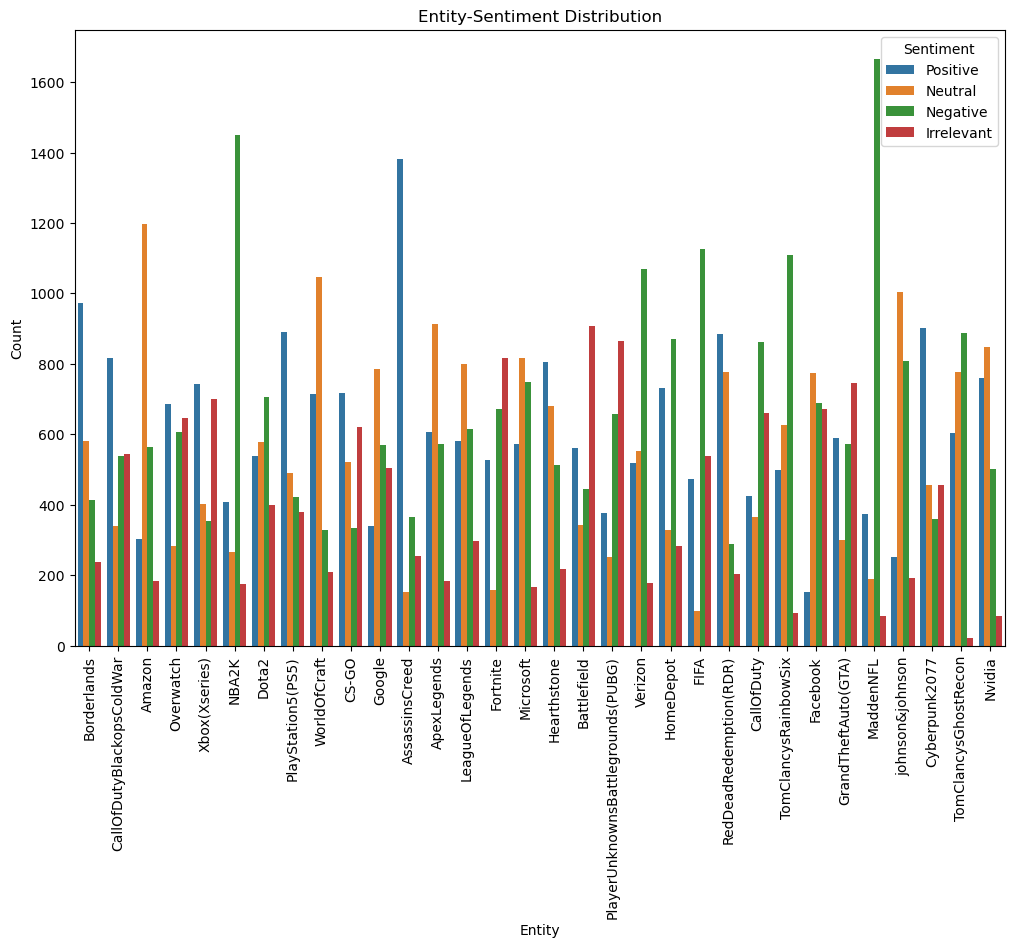

In [6]:
# Entity-Sentiment Distribution
plt.figure(figsize=(12, 8))
sns.countplot(x='Entity', hue='Sentiment', data=df)
plt.title('Entity-Sentiment Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()


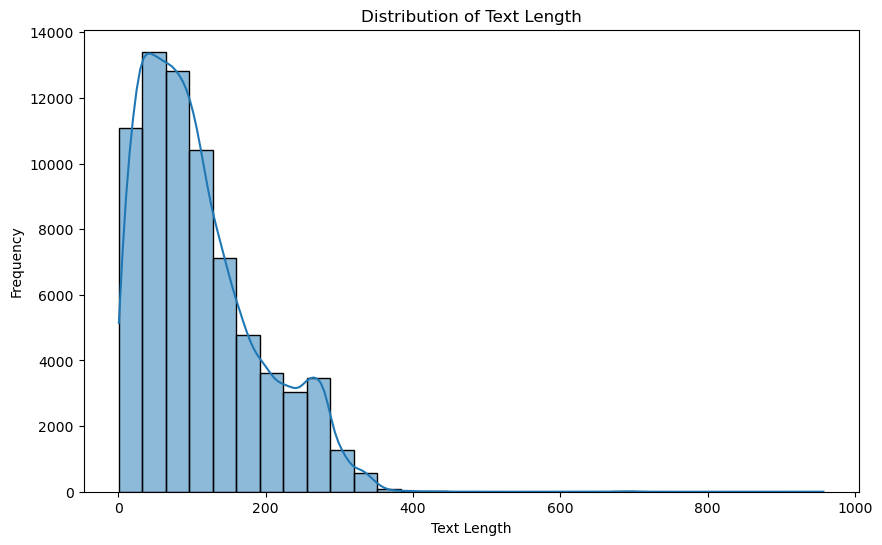

In [7]:
# Text length distribution
df['Text Length'] = df['Text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['Text Length'], bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

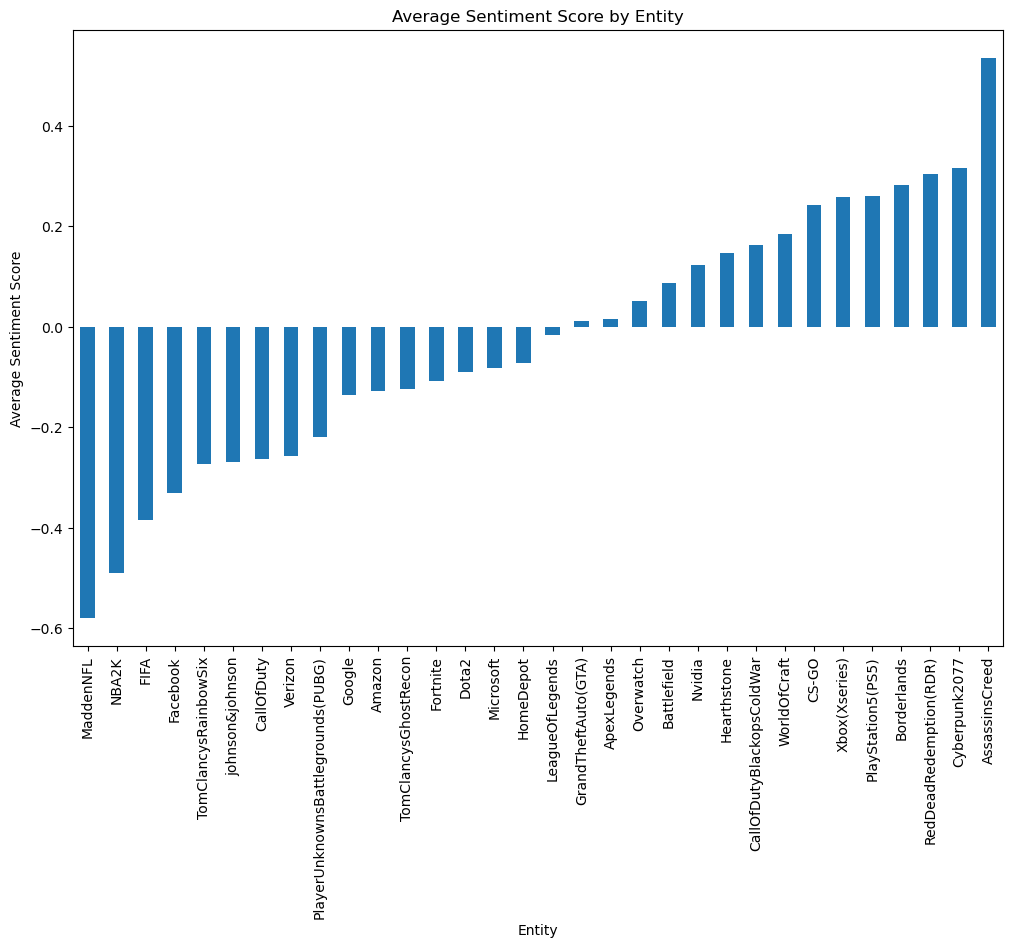

In [8]:
#  Average Sentiment Score by Entity
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['Sentiment Score'] = df['Sentiment'].map(sentiment_mapping)

avg_sentiment_by_entity = df.groupby('Entity')['Sentiment Score'].mean().sort_values()
plt.figure(figsize=(12, 8))
avg_sentiment_by_entity.plot(kind='bar')
plt.title('Average Sentiment Score by Entity')
plt.xlabel('Entity')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.show()

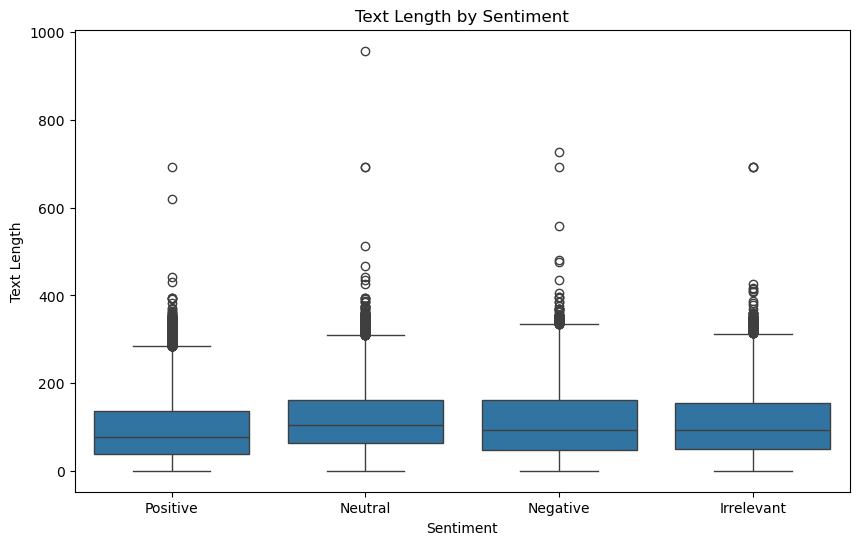

In [9]:
# Correlation Analysis between Text Length and Sentiment
df['Text Length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Text Length', data=df)
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

In [10]:
# Helper function to plot top N n-grams
def plot_top_ngrams(corpus, n=None, ngram_range=(1, 1), title='Top N-grams'):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    common_words = words_freq[:n]
    df_ngrams = pd.DataFrame(common_words, columns=['Ngram', 'Frequency'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Ngram', data=df_ngrams)
    plt.title(title)
    plt.show()

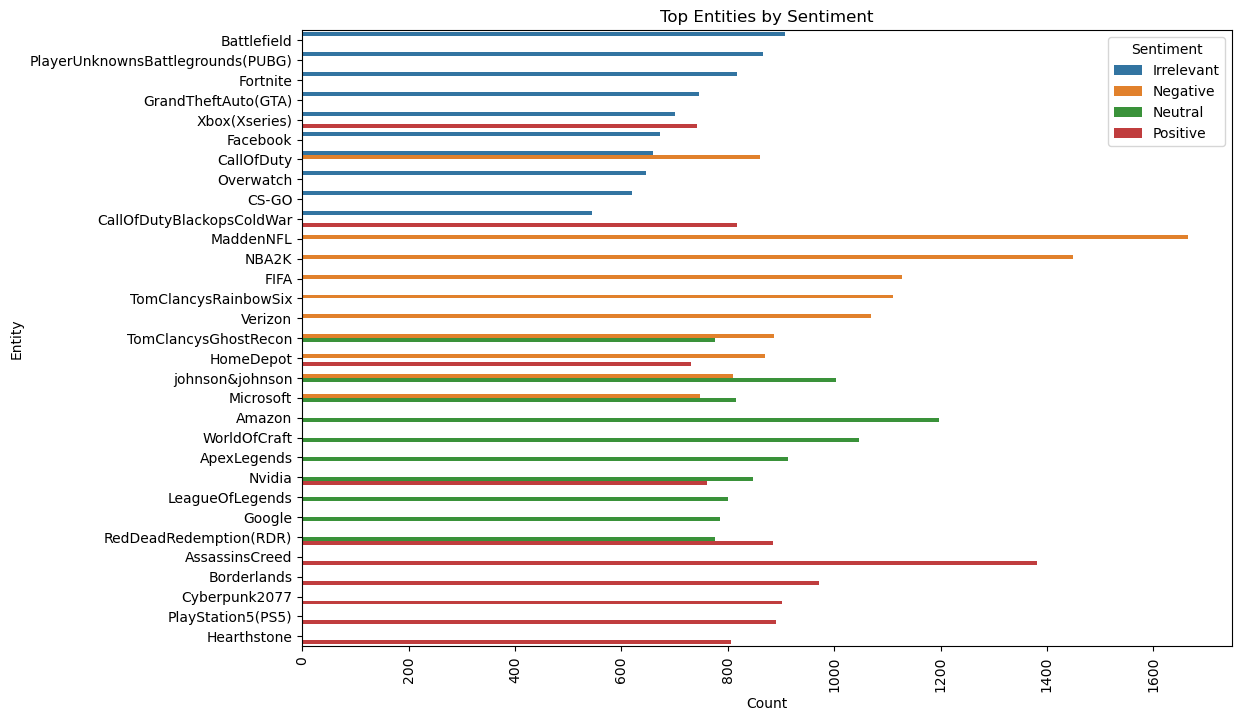

In [11]:
#  Top Entities by Sentiment
top_entities = df.groupby('Sentiment')['Entity'].value_counts().groupby(level=0).nlargest(10).reset_index(level=0, drop=True)
top_entities_df = top_entities.reset_index(name='Count')

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Entity', hue='Sentiment', data=top_entities_df)
plt.title('Top Entities by Sentiment')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()

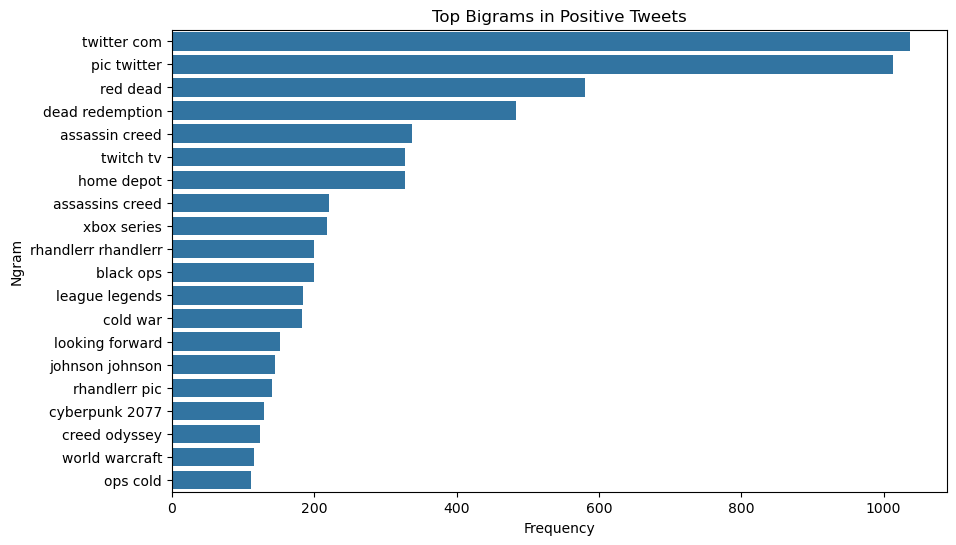

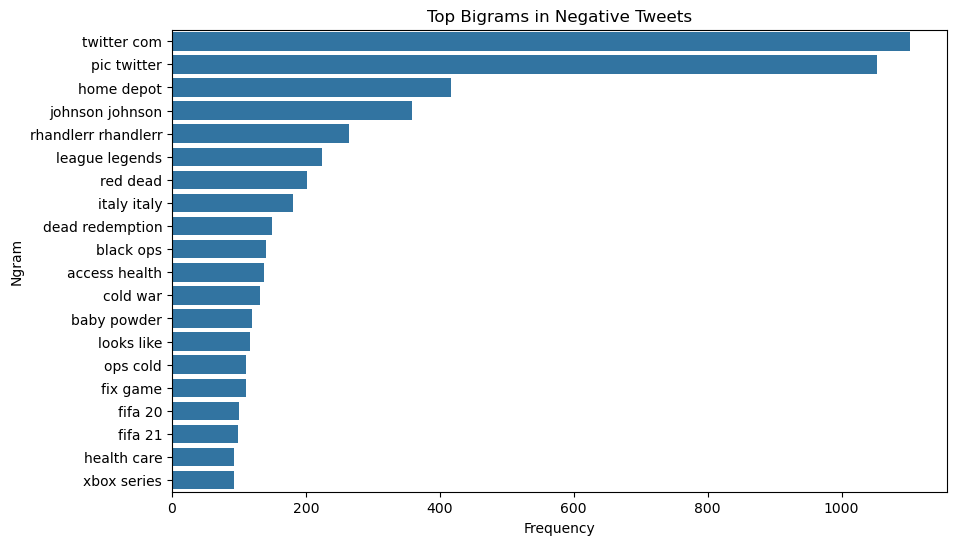

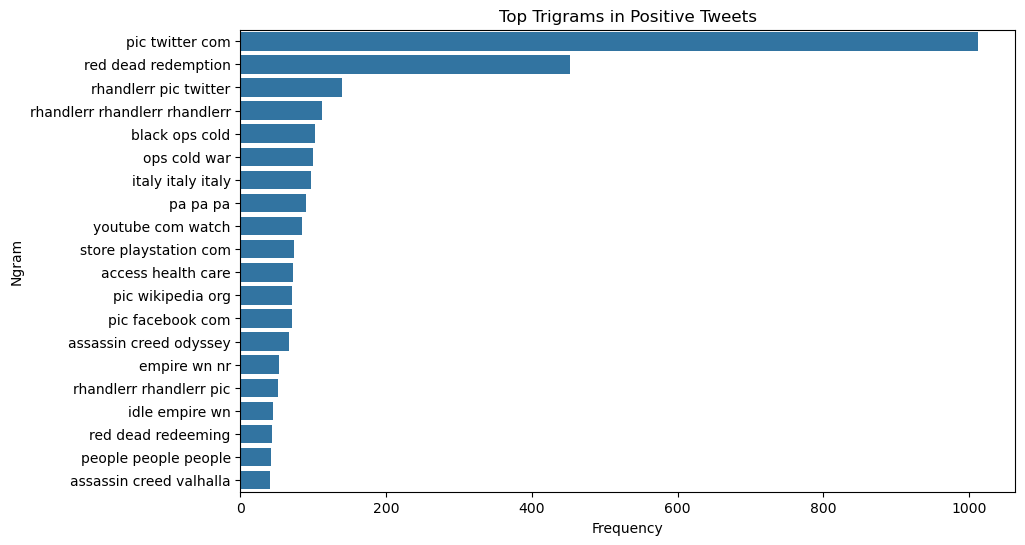

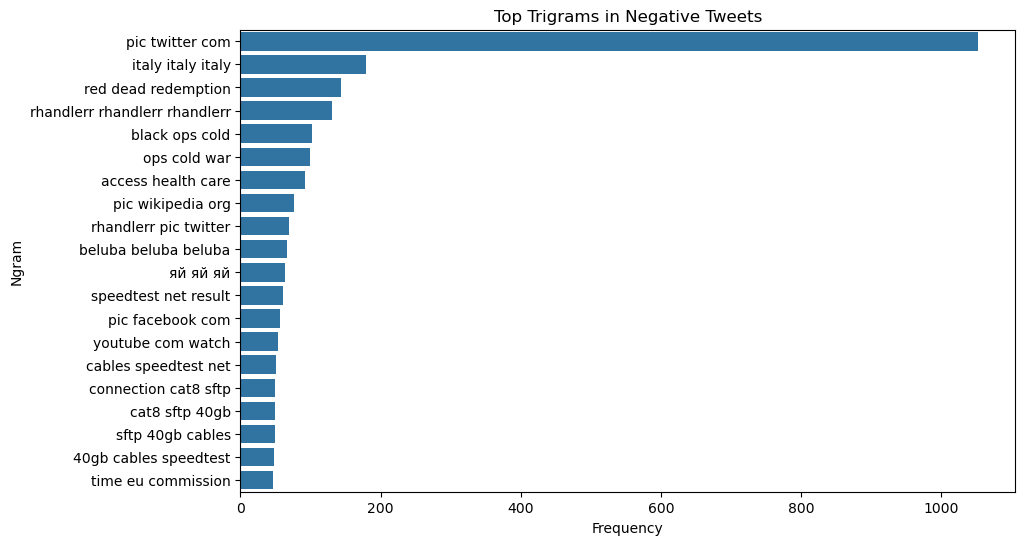

In [12]:
#  Bigram and Trigram Analysis for Positive and Negative Sentiments
positive_tweets = df[df['Sentiment'] == 'Positive']['Text']
negative_tweets = df[df['Sentiment'] == 'Negative']['Text']

plot_top_ngrams(positive_tweets, n=20, ngram_range=(2, 2), title='Top Bigrams in Positive Tweets')
plot_top_ngrams(negative_tweets, n=20, ngram_range=(2, 2), title='Top Bigrams in Negative Tweets')

plot_top_ngrams(positive_tweets, n=20, ngram_range=(3, 3), title='Top Trigrams in Positive Tweets')
plot_top_ngrams(negative_tweets, n=20, ngram_range=(3, 3), title='Top Trigrams in Negative Tweets')

In [16]:
# Check for duplicate values
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicate rows: 0


In [18]:
# Clean the text for topic modeling
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphanumeric characters
    text = text.lower()  # convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

df['Clean Text'] = df['Text'].apply(clean_text)

In [19]:
# Topic Modeling using LDA
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = count_vectorizer.fit_transform(df['Clean Text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics and their top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, count_vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
verizon home depot amazon shit good google facebook world fucking
Topic 2:
game new rhandlerr best nvidia league legends like playing borderlands
Topic 3:
game im like play xbox really dont fix ps eamaddennfl
Topic 4:
pubg love battlefield ban player creed good assassins italy youtube
Topic 5:
johnson dead red redemption facebook like baby google stop best


In [20]:
# Assign topics to tweets
topic_values = lda.transform(dtm)
df['Topic'] = topic_values.argmax(axis=1)

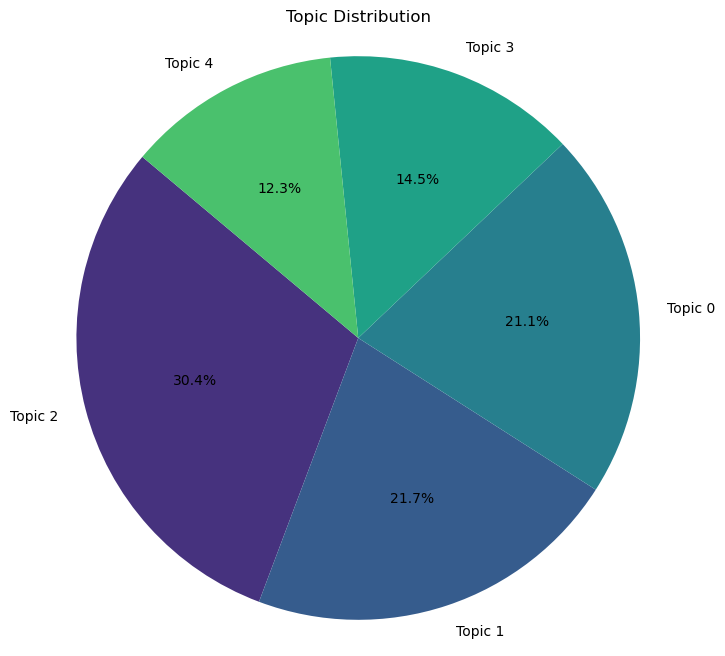

In [21]:
# Plot the distribution of topics
topic_counts = df['Topic'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(topic_counts, labels=[f"Topic {i}" for i in topic_counts.index], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title('Topic Distribution')
plt.axis('equal')
plt.show()

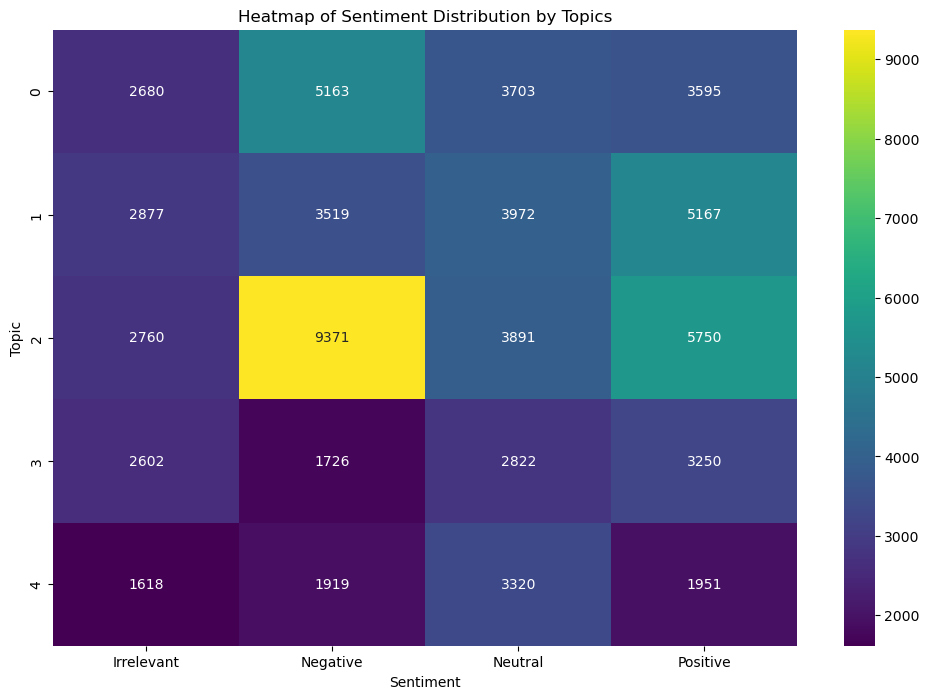

In [22]:
# Heatmap of sentiment distribution by topics
sentiment_topic_distribution = pd.crosstab(df['Topic'], df['Sentiment'])
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_topic_distribution, annot=True, cmap='viridis', fmt='d')
plt.title('Heatmap of Sentiment Distribution by Topics')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

In [23]:
# Max and Min Values for Each Sentiment for Each Topic
def get_extreme_sentiments(df, sentiment, extreme='max'):
    if extreme == 'max':
        return df[df['Sentiment'] == sentiment].groupby('Topic')['Clean Text'].max()
    elif extreme == 'min':
        return df[df['Sentiment'] == sentiment].groupby('Topic')['Clean Text'].min()

for sentiment in ['Positive', 'Negative', 'Neutral']:
    print(f"Max values for {sentiment} sentiment by topic:")
    print(get_extreme_sentiments(df, sentiment, 'max'))
    print("\n")
    print(f"Min values for {sentiment} sentiment by topic:")
    print(get_extreme_sentiments(df, sentiment, 'min'))
    print("\n")

Max values for Positive sentiment by topic:
Topic
0    yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...
1    zoe totally unfair deserve hate insane amount ...
2    zelda sector golden eye final fantasy little g...
3    yuumi super high cool fucking talking cat brau...
4                              youuu buzzfeed facebook
Name: Clean Text, dtype: object


Min values for Positive sentiment by topic:
Topic
0                                                     
1    absolute efficient amd gaming cpus already use...
2    absolutely burned hype many times wow video lo...
3                                           absolutely
4    abcnewsbayarea received text response verizon ...
Name: Clean Text, dtype: object


Max values for Negative sentiment by topic:
Topic
0                    zakawaqar really pretty great job
1    yup saw thing days ago thread current predicam...
2    youre wondering longer use paypal look bs taxe...
3    youtubeeauzqrk glitch call duty mobile ruined ...
4    zuckerb

In [24]:
# Check for duplicate values
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicate rows: 0


In [25]:
# Predictive Analysis
# Encode the target variable (Sentiment)
df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

In [26]:
# Drop any rows with NaN values in 'Sentiment'
df = df.dropna(subset=['Sentiment'])

In [27]:
# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Clean Text'])

In [28]:
# Target variable
y = df['Sentiment']

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train
y_train
y_test

37478    0.0
69453    1.0
45085    1.0
39575    1.0
38050   -1.0
        ... 
22517    1.0
19218    1.0
21324   -1.0
37490    0.0
43998    1.0
Name: Sentiment, Length: 11824, dtype: float64

In [31]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [32]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred

array([ 0.,  1.,  1., ..., -1.,  1.,  1.])

In [33]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7107577807848444
Confusion Matrix:
 [[3602  323  479]
 [ 824 1880  750]
 [ 692  352 2922]]
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.70      0.82      0.76      4404
         0.0       0.74      0.54      0.63      3454
         1.0       0.70      0.74      0.72      3966

    accuracy                           0.71     11824
   macro avg       0.71      0.70      0.70     11824
weighted avg       0.71      0.71      0.71     11824



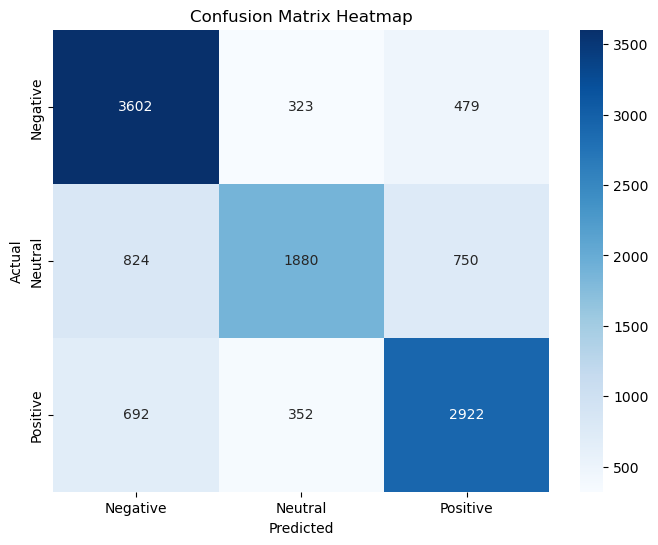

In [34]:
# Plot heatmap of the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()